## Initialization

In [8]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

## Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We recommend you build a generator with the ImageDataGenerator generator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as an usual CSV file.

In [3]:
#loading the data
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=16,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [4]:
#checking the general information about our datafile
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
#set the features and targets
features, target = next(train_flow)
print(features.shape,
target.shape)

(16, 150, 150, 3) (16,)


we have batch size of 16 images with 150x150 dimensions and with 3 channels.

## EDA

In [6]:
#let's look at real_age

labels['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

We see the mean of the age is around 31 years, with the minimum of 1, maximum of 100.

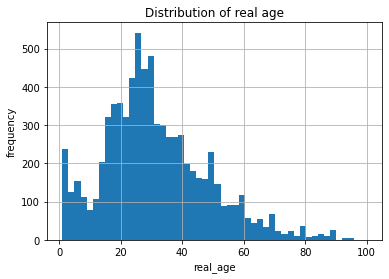

In [9]:
#let's look at the distribution

labels['real_age'].hist(bins=50)
plt.title('Distribution of real age')
plt.xlabel('real_age')
plt.ylabel('frequency')
plt.show()

We observe a peak at between 20 and 40. We can use a scatter plot to see the exact count.

<AxesSubplot:xlabel='real_age', ylabel='count'>

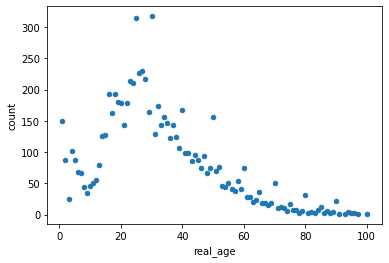

In [10]:
#scatter plot

dist = labels['real_age'].value_counts().reset_index()
dist.columns = ['real_age','count']
dist.plot(kind = 'scatter', x='real_age', y='count')

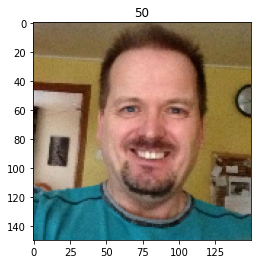

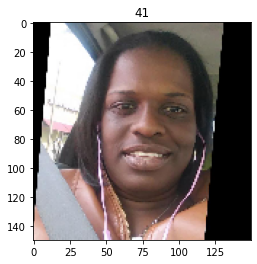

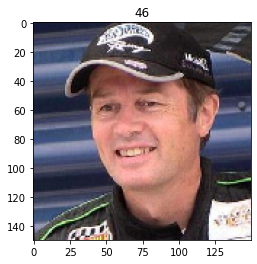

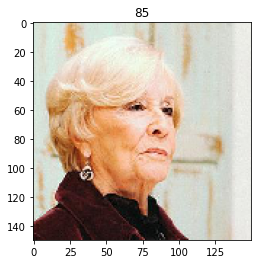

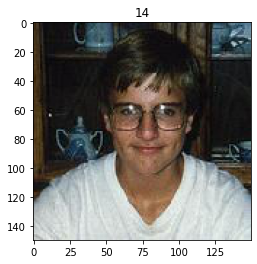

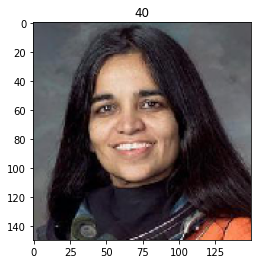

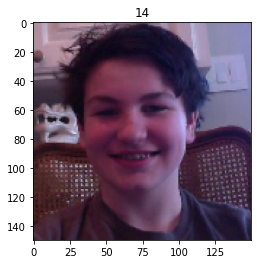

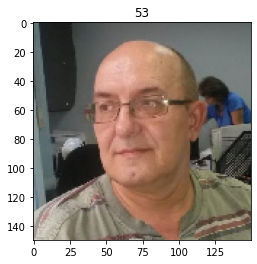

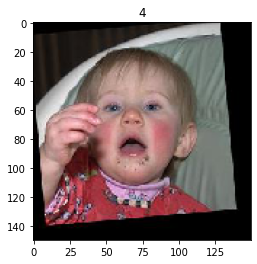

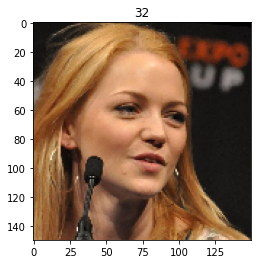

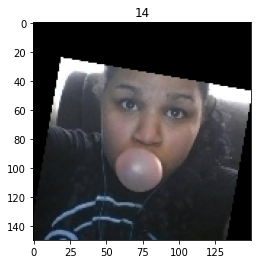

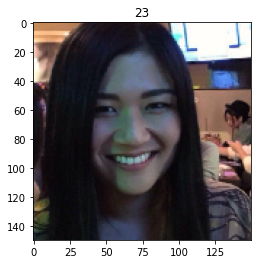

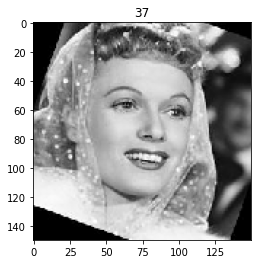

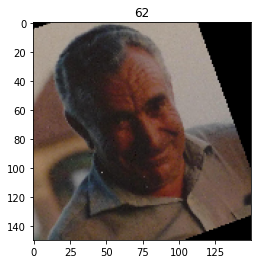

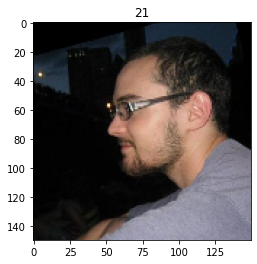

In [12]:
#check the images

for age, pic in zip(target[:15], features[:15]):
    plt.figure()
    plt.title(age)
    plt.imshow(pic)

### Findings

The scatter plot shows that our data consists of image of people that are 10-50. The number people with age fall outside of this range decreases. The histogram is skewed to the right. By training with less 'younger' and 'older' people might lead to our model struggles to correctly determine the young and old customers. 

Therefore:

We will add a ReLU activation for more layers to model.

We will use adam algorthm with a low learning rate to train our model. 

Usage of ImageDataGenerator from Keras for easy data loading.

Add augmentation because of skew in distribution.

ResNet architecture to improve model. 


## Modelling

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.

In [2]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [13]:
def load_train(path):
    
    """
    It loads the train part of dataset from path
    """
    
    labels = pd.read_csv(path + 'labels.csv')
    directory = path + 'final_files/'
    train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, vertical_flip=True, validation_split=0.25)
    train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=labels,
                                                            directory=directory,
                                                            x_col = 'file_name', 
                                                            y_col = 'real_age', 
                                                            target_size=(224, 224),
                                                            batch_size=16,
                                                            class_mode='raw',
                                                            subset='training',
                                                            seed=12345)

    return train_datagen_flow

In [14]:
def load_test(path):
    
    """
    It loads the validation/test part of dataset from path
    """
    
    labels = pd.read_csv(path + 'labels.csv')
    directory = path + 'final_files/'
    test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(dataframe=df,
                                                            directory=directory,
                                                            x_col = 'file_name', 
                                                            y_col = 'real_age',
                                                            target_size=(224, 224),
                                                            batch_size=16,
                                                            class_mode='raw',
                                                            subset='validation',
                                                            seed=12345)

    return test_datagen_flow

In [15]:
def create_model(input_shape):
    
    """
    It defines the model
    """
    
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    optimizer = Adam(lr=0.0001) 
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

    return model

In [16]:
def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

### Prepare the Script to Run on the GPU Platform

Given you've defined the necessary functions you can compose a script for the GPU platform, download it via the "File|Open..." menu, and to upload it later for running on the GPU platform.

N.B.: The script should include the initialization section as well. An example of this is shown below.

In [17]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

Place the output from the GPU platform as an Markdown cell here.

Train for 356 steps, validate for 119 steps


Epoch 1/10

2022-10-21 00:57:20.345878: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] 


2022-10-21 00:57:20.612662: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] 

Successfully opened dynamic library libcudnn.so.7

356/356 - 61s - loss: 221.7558 - mae: 11.1288 - val_loss: 552.7020 - val_mae: 18.3374

Epoch 2/10

356/356 - 39s - loss: 110.2420 - mae: 8.0328 - val_loss: 142.6973 - val_mae: 8.6881

Epoch 3/10

356/356 - 39s - loss: 90.0746 - mae: 7.1827 - val_loss: 109.3857 - val_mae: 8.1962

Epoch 4/10

356/356 - 39s - loss: 72.9249 - mae: 6.4416 - val_loss: 171.6232 - val_mae: 10.6464

Epoch 5/10

356/356 - 39s - loss: 63.4476 - mae: 6.0194 - val_loss: 81.1280 - val_mae: 6.7160

Epoch 6/10

356/356 - 39s - loss: 55.8736 - mae: 5.6775 - val_loss: 127.6285 - val_mae: 8.8720

Epoch 7/10

356/356 - 39s - loss: 47.9425 - mae: 5.2477 - val_loss: 114.6607 - val_mae: 7.9110

Epoch 8/10

356/356 - 40s - loss: 39.7921 - mae: 4.8439 - val_loss: 79.8334 - val_mae: 6.6635

Epoch 9/10

356/356 - 40s - loss: 33.5215 - mae: 4.3878 - val_loss: 77.6104 - val_mae: 6.6398

Epoch 10/10

356/356 - 39s - loss: 31.9717 - mae: 4.2658 - val_loss: 78.3723 - val_mae: 6.8997

WARNING:tensorflow:sample_weight modes were coerced from

  ...
    to  
  ['...']
  
119/119 - 10s - loss: 78.3723 - mae: 6.8997


Test MAE: 6.8997




## Conclusions

We have successfully getting a mae under 7 for our test set. Our model should be able to determine a person's age by a photo. This can be utilized for several purposes such as collecting data on customers to identify similar purchases habits between customers of the same age, using that data to target advertisements to certain age groups, and determining the age of a customer at a checkout counter to automate the approval or disapproval of a sale of alcohol. 